# Train / Test split
We split **CNS-DB** into train and test subset. We rely on Murcko scaffold to bucket the molecules to limit the leak of information from the test set into the training data. We rely on `Twinning` algorithm to maintain distribution similarity between the splits and avoid randomness.

This setting is still far from a realistic application where out-of-distribution molecules are expected.

In [25]:
import functools
import os
import shelve
import itertools
import twinning
from typing import List, Iterable, Dict

import pandas as pd
import numpy as np
import requests_cache

from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit import DataStructs
import rdkit.Chem

import datamol as dm
from molfeat.trans.fp import FPVecTransformer

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import GroupKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from xgboost import XGBClassifier, XGBRegressor

from scipy.stats import wasserstein_distance, ks_2samp, wilcoxon

from utils import get_ecfp4_count_fingerprint

from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
tqdm.pandas()


def get_equivalence_ranks_weighted(results: List[Iterable[float]], results_weights: List[float], pval: float=0.01) -> List:
    """
    Assigns an equivalence rank to each list of results based on Wilcoxon signed-rank test.
    :param results: a list of iterables of results, if results_weights is supplied, all iterables are assumed to be of the same length.
    :param results_weights: a list of weights, applied to all iterables in results list.
    :param pval: threshold p-value of the t-test result
    :return: a list of ranks, in the order of the original list of results iterables.
    """
    results = [(i, r) for i, r in enumerate(results)]
    tot_w = sum(results_weights)
    results_weights = [w/tot_w for w in results_weights]
    results = sorted(
        results,
        key=lambda x: sum(r*w for r, w in zip(x[-1], results_weights)),
        reverse=True
    ) # Sort descending by weighted results average.

    _eq_rank = 1
    _eq_res = results[0][-1]
    for i, r in enumerate(results):   # At each step, if the next set of results is statistically smaller than the top one in the current eq rank - increase the rank.
        _, is_less_p_value = wilcoxon(r[-1], _eq_res, alternative="less", correction=True)
        if is_less_p_value <= pval:
            _eq_rank += 1
            _eq_res = r[-1]

        results[i] = (r[0], _eq_rank)
    results = sorted(results, key=lambda x: x[0]) # Sort in the original order.
    return [r[-1] for r in results]


In [6]:
df_cns_db = pd.read_csv("dataset_intermediaries/03_cns_db_raw.tsv", sep="\t")
print(f"Read dataset: {len(df_cns_db)} molecules")

_n_pre_removal = len(df_cns_db)
df_cns_db = df_cns_db[df_cns_db["BBB+/BBB-_group"] != "D"]
print(f"Excluded {_n_pre_removal - len(df_cns_db) } molecules assigned to BBB+/BBB- group D (both BBB+ and BBB- reported, assigned the most frequent): {_n_pre_removal} -> {len(df_cns_db)}")

_n_pre_removal = len(df_cns_db)
df_cns_db = df_cns_db[df_cns_db.smiles.apply(lambda x: rdkit.Chem.Descriptors.ExactMolWt(rdkit.Chem.MolFromSmiles(x)) <= 1000)]
print(f"Excluded {_n_pre_removal - len(df_cns_db) } molecules with molecular weight > 1000 Da: {_n_pre_removal} -> {len(df_cns_db)}")

INCHI_TO_DROP = {
    "InChI=1S/C25H32ClN3O3S/c26-20-3-1-5-23(17-20)32-22-10-15-28(16-11-22)14-9-21-4-2-13-29(21)33(30,31)24-7-6-19-8-12-27-25(19)18-24/h1,3,5-8,12,17-18,21-22,27,33H,2,4,9-11,13-16H2,(H,30,31)", # Pointer exception when generating conformers, looks similar to https://github.com/rdkit/rdkit/issues/200
}
_n_pre_removal = len(df_cns_db)
df_cns_db = df_cns_db[df_cns_db.inchi.apply(lambda x: x not in INCHI_TO_DROP)].reset_index(drop=True)
print(f"Removed {_n_pre_removal-len(df_cns_db)} blacklisted molecules: {_n_pre_removal} -> {len(df_cns_db)}")

# Conformers generation and exclusion of cases that could not be handled

N_CONFORMERS = 25
f_gen = functools.partial(dm.conformers.generate, n_confs=N_CONFORMERS, ignore_failure=True, enforce_chirality=False)
# Not enforcing chirality was necessary for some of the larger molecules - otherwise conformers could not be generated locally.
with dm.without_rdkit_log():  # This hides UFFTYPER: Unrecognised atom type: Ar3+4, RuntimeWarning: invalid value encountered in scalar divide 'if E - minE <= ewindow and (E - minE) / rotatable_bonds <= eratio',  UFFTYPER: Unrecognized charge state for atom: 1 , similar one for atom: 17
   df_cns_db["mol"] = df_cns_db.smiles.apply(rdkit.Chem.MolFromSmiles)
   df_cns_db["mol_conformers"] = process_map(f_gen, df_cns_db.mol)

_n_pre_removal = len(df_cns_db)
df_cns_db = df_cns_db[df_cns_db.mol_conformers.apply(lambda x: pd.notna(x) and len(x.GetConformers()) > 0)].reset_index(drop=True)
print(f"Removed {_n_pre_removal - len(df_cns_db)} molecules for which we could not generate conformers: {_n_pre_removal} -> {len(df_cns_db)}")

# Useable logBB values
print(f"Molecules logBB values remaining: {sum(pd.notna(df_cns_db.logBB_group))}")
print(f"Molecules with logBB values - {sum(df_cns_db.logBB_group == 'D')} group D (multiple discrepant values reported - taking the most common) molecules {sum(pd.notna(df_cns_db.logBB_group))} (all available) -> {sum(df_cns_db.logBB_group.apply(lambda x: pd.notna(x) and x != 'D'))} (filtered)")

Read dataset: 3414 molecules
Excluded 70 molecules assigned to BBB+/BBB- group D (both BBB+ and BBB- reported, assigned the most frequent): 3414 -> 3344
Excluded 21 molecules with molecular weight > 1000 Da: 3344 -> 3323
Removed 1 blacklisted molecules: 3323 -> 3322


/var/folders/h8/664cd3cn5s52nmms0vspxkj80000gn/T/ipykernel_65565/668902460.py:26: TqdmWarning: Iterable length 3322 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  df_b3db_kc["mol_conformers"] = process_map(f_gen, df_b3db_kc.mol )
  0%|          | 0/3322 [00:00<?, ?it/s][19:30:57] UFFTYPER: Unrecognized atom type: Ar3+4 (0)
[19:30:57] UFFTYPER: Unrecognized atom type: Ar3+4 (0)
[19:30:57] UFFTYPER: Unrecognized atom type: Ar3+4 (0)
[19:30:57] UFFTYPER: Unrecognized atom type: Ar3+4 (0)
[19:30:57] UFFTYPER: Unrecognized atom type: Ar3+4 (0)
[19:30:57] UFFTYPER: Unrecognized atom type: Ar3+4 (0)
  3%|▎         | 93/3322 [00:03<00:43, 74.47it/s] [19:30:58] UFFTYPER: Unrecognized atom type: Ca1+2 (0)
[19:30:58] UFFTYPER: Unrecognized atom type: Ca1+2 (20)
[19:30:58] UFFTYPER: Unrecognized atom type: Ca1+2 (20)
[19:30:58] UFFTYPER: Unrecognized atom type: Ca1+2 (20)
[19:30:58] UFFTYPER: Unrecognized atom type: Ca1+2 (20)
[

Removed 0 molecules for which we could not generate conformers: 3322 -> 3322
Molecules logBB values remaining: 947
Molecules with logBB values - 69 group D (multiple discrepant values reported - taking the most common) molecules 947 (all available) -> 878 (filtered)


## Murcko scaffolds generation

Upon generating Murcko scaffolds, we identify those with disproportionately large number of molecules and further split those based on their similarity (measured by ECFP4-count Tanimoto similarity, using outlier-specific thersholds).  

Found a total of 1665 Murcko scaffolds across 3322 molecules (446 / 878 in filtered regression setting)
Identified the following scaffold outliers: '' (n=222), 'c1ccccc1' (n=221), 'O=C1C=CC2C(=C1)CCC1C3CCCC3CCC21' (n=77)


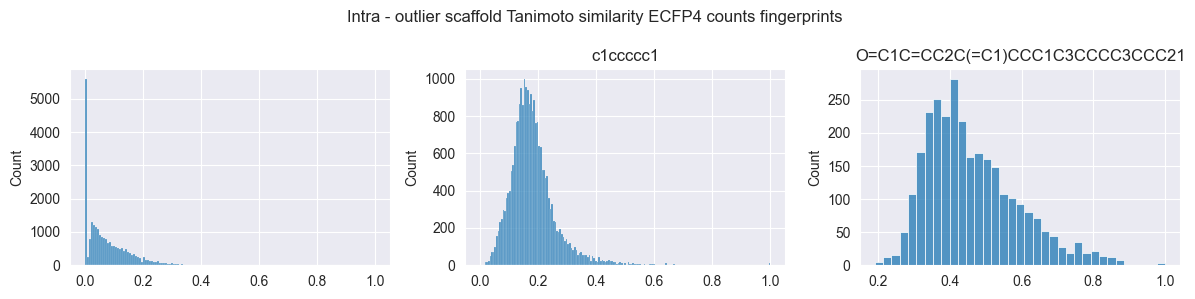

In [7]:
df_cns_db["murcko_scaffold"] = df_cns_db.smiles.apply(rdkit.Chem.Scaffolds.MurckoScaffold.MurckoScaffoldSmiles)
_reg = df_cns_db[df_cns_db.logBB_group.apply(lambda x: pd.notna(x) and x != 'D')]
print(f"Found a total of {df_cns_db.murcko_scaffold.nunique()} Murcko scaffolds across {len(df_cns_db)} molecules ({_reg.murcko_scaffold.nunique()} / {len(_reg)} in filtered regression setting)")
scaffold_outliers = df_cns_db.murcko_scaffold.value_counts()[:3].to_dict()
print(f"Identified the following scaffold outliers: " + ", ".join(list(f"'{k}' (n={v})" for k, v in scaffold_outliers.items())))

df_cns_db["ecfp4_count_fingerprint"] = df_cns_db.smiles.apply(get_ecfp4_count_fingerprint)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for ax_i, o in enumerate(scaffold_outliers):
    fingerprints = list(df_cns_db[df_cns_db.murcko_scaffold == o].ecfp4_count_fingerprint)
    similarities = []
    
    for i in range(len(fingerprints)):
        for j in range(i+1, len(fingerprints)):  # Avoid repeating comparisons
            sim = TanimotoSimilarity(fingerprints[i], fingerprints[j])
            similarities.append(sim)    
    _ax = axs[ax_i]    
    _ax.set_title(o)
    sns.histplot(np.array(similarities), ax=_ax)
fig.suptitle("Intra - outlier scaffold Tanimoto similarity ECFP4 counts fingerprints")
fig.tight_layout()    

Split the scaffolds into 1964 scaffold-groups to account for outliers.


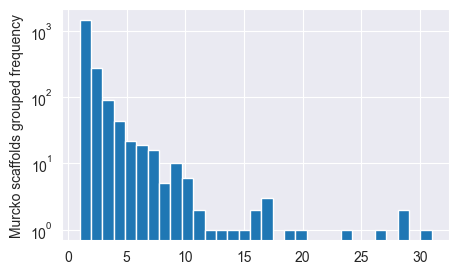

In [8]:
# Introduce a new column, containing Murcko scaffolds with the outliers (disproportionately large number of molecules) being further split into groups.
SCAFFOLD_GROUP_SIMILARITY_THRESHOLD = 0.5

df_cns_db['murcko_scaffold_grouped'] = df_cns_db.murcko_scaffold
for outlier in scaffold_outliers:
    # Filter molecules belonging to the current outlier scaffold
    outlier_mols = df_cns_db[df_cns_db.murcko_scaffold == outlier]
    # Initialize group IDs
    group_id = 0
    
    while not outlier_mols.empty:
        # Find molecules similar to the reference molecule
        ref_fp = outlier_mols.iloc[0].ecfp4_count_fingerprint
        group = outlier_mols[outlier_mols.ecfp4_count_fingerprint.apply(lambda x: DataStructs.TanimotoSimilarity(ref_fp, x) >= SCAFFOLD_GROUP_SIMILARITY_THRESHOLD)]
        
        # Assign a new scaffold identifier for these molecules
        new_scaffold = f"{outlier}_group_{group_id}"
        df_cns_db.loc[group.index, 'murcko_scaffold_grouped'] = new_scaffold
        
        # Remove these molecules from the outlier_mols DataFrame
        outlier_mols = outlier_mols.drop(group.index)
        group_id += 1

print(f"Split the scaffolds into {df_cns_db.murcko_scaffold_grouped.nunique()} scaffold-groups to account for outliers.")

_ = df_cns_db.murcko_scaffold_grouped.value_counts().plot(kind="hist", bins=31, log=True, ylabel='Murcko scaffolds grouped frequency', figsize=(5, 3))

## Pre-split baseline
Here we iterate over non-optimised, default models and featurisers providing unfiltered sets of descriptors to:
  - learn which featurisers and models might be a good start for investigating feature selection
  - establish a baseline for improved models

In [ ]:
featurisers = [
    ("ecfp", False),
    ("ecfp-count", False),
    ("avalon", False),
    ("maccs", False),
    ("desc3D", True),
    ("desc2D", False),
    ("mordred", False),  # During the last run, this got unworkingly slow.
    ("cats2D", False),
    ("cats3D", True),
    ("pharm2D", False),
    ("pharm3D", True),
    ("skeys", False),
    ("electroshape", True)
    #("usr", True), #errors processing molecules
    #("usrcat", False), #errors processing molecules
]

df_cns_db_shuffled = df_cns_db.sample(frac=1, random_state=42)
cns_db_shuffled_descriptors_cache = {}
for f, uses_3d in featurisers:
    print(f"Generating descriptors for featuriser '{f}'")
    transformer = FPVecTransformer(kind=f, dtype=float, n_jobs=16, verbose=True)  
    _df_desc = pd.DataFrame(transformer(df_cns_db_shuffled["mol_conformers" if uses_3d else "mol"]), columns=transformer.columns)
    # Some descriptors are empty, with failures to calculate - Avalon is a good example of this happening due to outdated dependencies.
    _n_desc_before_nan_removal = len(list(_df_desc))
    _df_desc = _df_desc.dropna(axis=1)
    if len(list(_df_desc)) != _n_desc_before_nan_removal:
        print(f" removed { _n_desc_before_nan_removal-len(list(_df_desc)) } empty descriptors: {_n_desc_before_nan_removal} -> {len(list(_df_desc))}"  )

    # For desc2D, there are duplicate descriptors coming out of the transformer, these break XGBoost.
    _n_desc_before_duplicate_columns = len(list(_df_desc))
    _df_desc = _df_desc.loc[:,~_df_desc.columns.duplicated()].copy()
    if len(list(_df_desc)) != _n_desc_before_duplicate_columns:
        print(f" removed { _n_desc_before_nan_removal-len(list(_df_desc)) } duplicate descriptors: {_n_desc_before_nan_removal} -> {len(list(_df_desc))}"  )
    cns_db_shuffled_descriptors_cache[f] = _df_desc


#### ChemAxon descriptors

The descriptors are obtained: 
    - first by extracting precalculated values extracte from ChEMBL database
    - for the molecules not present in ChEMBL, we utilise Chemaxon's property calculator available via [Amazon AWS Marketplace](https://aws.amazon.com/marketplace/seller-profile?id=464bcc5a-31fc-41d9-b9dc-9a43fa5f3634).
    - we rely on CNS MPO endpoint as it provides prediction for lipophilicity - relevant descriptors, which uses 7 "units" of calculation. At the moment of writing, this corresponds to 0.07 USD per structure for standard user. 

The code below requires **AWS_MARKETPLACE_CHEMAXON_API_KEY** environment variable. 

TO VERIFY: The initial finding is that pKa does not distinguish between acidic or basic and the returned values are nowhere near the values ChEMBL or MOE. E.g. for **O=C1N[C@H](CCCl)Oc2ccccc21**, it returns 0.16. MOE has acidic ~13, basic ~16, ChEMBL (Chemaxon) only has acidic at ~13. CNS MPO terminology suggests it should be the pKa of the most basic group of the compound.

In [11]:
df_chembl_molecule_properties = pd.read_csv("../data/ChEMBL/chembl_molecule_properties.csv.gz", low_memory=False)

"""
ChEMBL has 8 more standard_inchi_key than standard_inchi (i.e. the inchi<->inchi_key relationship within the database is not 1-1).
We could rely on InChI in optimising the coverage (it captures about 3.5% more CNS-DB compounds). However, this introduces additional complexity for a limited gain.
"""
_smiles_to_properties = {
    r["canonical_smiles"]: {
        "logd": r["cx_logd"],
        "logp": r["cx_logp"],
        "pka_b": r["cx_most_bpka"],
        "source": "ChEMBL",
    } 
    for r in df_chembl_molecule_properties.to_dict("records") if "canonical_smiles" in r
}
print(f"Extracted {len(_smiles_to_properties)} unique SMILES -> property records from {len(df_chembl_molecule_properties)} ChEMBL molecules")

Extracted 2409118 unique SMILES -> property records from 2431025 ChEMBL molecules


In [12]:
chemaxon_aws_shelf_path = "caches/chemaxon_aws_shelf"
chemaxon_aws_session=requests_cache.CachedSession("caches/chemaxon_aws_session.sqlite", allowable_codes=[200], allowable_methods=["GET", "POST"])
CHEMAXON_CNS_MPO_ENDPOINT = "https://api.calculators.cxn.io/rest-v1/calculator/calculate/cns-mpo"

with shelve.open(chemaxon_aws_shelf_path) as s:
    print("Current shelf size:", len(s))

def _ca_res_to_props(d):
    _ps = {p["name"]:p["value"] for p in  d["properties"]}

    return {
        "logd": _ps["logd"],
        "logp": _ps["logd"],
        "pka_b": _ps["pka"],
        "source": "Chemaxon API",
    }

with (shelve.open(chemaxon_aws_shelf_path) as chemaxon_shelf):  # We use a two-level cache as a defensive mechanism in case of a single backup issues. Streamlining the shelf access is not deemed a priority given the usage pattern.

    for k, v in chemaxon_shelf.items():
        _smiles_to_properties[k] = _ca_res_to_props(v)

    def get_chemaxon_properties(smiles, allow_api_calls=False):
        assert len(_smiles_to_properties) > 3400
        if smiles not in _smiles_to_properties or pd.isna(_smiles_to_properties[smiles]["logp"]) or pd.isna(_smiles_to_properties[smiles]["logd"]):
            if allow_api_calls:
                print(f"Querying Chemaxon endpoint for: {smiles}")

                res = chemaxon_aws_session.post(
                    url=CHEMAXON_CNS_MPO_ENDPOINT,
                    headers={"x-api-key": os.environ["AWS_MARKETPLACE_CHEMAXON_API_KEY"]},
                    json={"structure": smiles}
                )
                res.raise_for_status()
                d = res.json()
                
                chemaxon_shelf[smiles] = d
                _smiles_to_properties[smiles]=_ca_res_to_props(chemaxon_shelf[smiles])
        return _smiles_to_properties[smiles]
    
    # NOTE: allow_api_calls needs to be enabled to generate descriptors
    df_chemaxon_descriptors = pd.DataFrame([
        {"smiles": smi} | get_chemaxon_properties(smi, allow_api_calls=False) for smi in df_cns_db_shuffled.smiles])

print(f"Calculated logP, logD and most basic pKa for {len(df_chemaxon_descriptors)} molecules: {df_chemaxon_descriptors.source.value_counts()['ChEMBL']} using ChEMBL, {df_chemaxon_descriptors.source.value_counts()['Chemaxon API']} using Chemaxon API.")
print(f"Imputing {sum(pd.isna(df_chemaxon_descriptors.pka_b))} missing most basic group pKa with 0. Used here to allow data exploration as some of the algorithms cannot work on missing values.")
df_chemaxon_descriptors=df_chemaxon_descriptors.fillna(0)
# df_chemaxon_descriptors.describe()
featurisers.append(("desc2D+chemaxon", False))
cns_db_shuffled_descriptors_cache["desc2D+chemaxon"] = pd.concat([cns_db_shuffled_descriptors_cache["desc2D"], df_chemaxon_descriptors[["logp", "logd", "pka_b"]]], axis=1)

Current shelf size: 602
Calculated logP, logD and most basic pKa for 3322 molecules: 2779 using ChEMBL, 543 using Chemaxon API.
Imputing 989 missing most basic group pKa with 0. Used here to allow data exploration as some of the algorithms cannot work on missing values.


In [140]:
from typing import Tuple
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge # , Lasso, BayesianRidge, SGDRegressor, SGDClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_validate, StratifiedGroupKFold
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, ExtraTreesRegressor, \
    ExtraTreesClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB

def get_classification_models():
    return [
        DummyClassifier(random_state=42),
        LogisticRegression(random_state=42, max_iter=1000, solver="liblinear"),  # Adding scaler does not change the results considerably.
        SVC(random_state=42),
        #SGDClassifier(random_state=42),
        GaussianNB(),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42),
        ExtraTreesClassifier(random_state=42),
        AdaBoostClassifier(random_state=42),
        XGBClassifier(random_state=42),
]

def get_regression_models():
    return [
        DummyRegressor(),
        LinearRegression(),
        #Lasso(random_state=42),
        Ridge(random_state=42),
        SVR(),
        # SGDRegressor(random_state=42),
        # BayesianRidge(), # Dataset is imbalanced.
        DecisionTreeRegressor(random_state=42),
        ExtraTreesRegressor(random_state=42),
        RandomForestRegressor(random_state=42),
        AdaBoostRegressor(random_state=42),
        XGBRegressor(random_state=42)
    ]

classification_metrics = ["roc_auc", "f1", "precision", "recall", "accuracy", "balanced_accuracy"]
classification_main_metric = "test_balanced_accuracy"
cns_db_classification_target = lambda x: 1 if x["BBB+/BBB-"] == "BBB+" else 0
regression_metrics = ["neg_mean_squared_error", "r2", "explained_variance"]
regression_main_metric = "test_r2"
cns_db_regression_target = lambda x: x.logBB
groups_murcko_scaffold_group = lambda x: x.murcko_scaffold_grouped

cns_db_shuffled_idx_all = [True] * len(df_cns_db_shuffled)
cns_db_shuffled_idx_regression = list(df_cns_db_shuffled.logBB_group.apply(lambda x: pd.notna(x) and x != 'D'))

def evaluate_setting(
    data: pd.DataFrame, 
    feature_cache: Dict[str, pd.DataFrame], 
    featurisers: List[str], 
    models: List[BaseEstimator], 
    data_idx, 
    metrics, 
    target_func, 
    groups_func
) -> pd.DataFrame:
    """
    Evaluates different feature sets and algorithms from the specified lists using grouped 5-fold CV on the given datasets.
    Returns test metrics.  
    """
    results = {}
    print(f"Started evaluation using {sum(data_idx)} compounds") 
    for _f in featurisers:
        print(f"Evaluating {_f}")
        results[_f] = {}
        for _m in models:
            _mn = _m.__class__.__name__
            print(f" - model: {_mn}")
            _y = data[data_idx].apply(axis=1, func=target_func)
              
            results[_f][_mn] = cross_validate(
                _m,
                X=feature_cache[_f][data_idx],
                y=_y,
                groups=data[data_idx].apply(axis=1, func=groups_func),
                scoring=metrics,
                cv=GroupKFold(5) if type_of_target(_y) == "continuous" else StratifiedGroupKFold(5, shuffle=True, random_state=42),  # This further shuffles each class's samples before splitting but doesn't provide global shuffle.
                verbose=1,
                return_indices=True
            )
    _df_res_test = pd.DataFrame(
        {
            "featuriser": _f,
            "model": _m,
            "metric": _met,
            "results": _cvr[_met],
            "results_weights": [
                (len(_cvr["indices"]["test"][i]) / (len(_cvr["indices"]["test"][i]) + len(_cvr["indices"]["train"][i])))
                for i in range(len(_cvr["indices"]["train"]))
            ],
        }
        for _f, _v in results.items()
        for _m, _cvr in _v.items()
        for _met in _cvr
        if _met.startswith("test")
    )
    _df_res_test["results_w_avg"] = _df_res_test.apply(axis=1, func=lambda x: sum(r * w for r, w in zip(x.results, x.results_weights)))
    
    return _df_res_test, results


def plot_test_results_by_metric(df_evaluation_results: pd.DataFrame, metric: str, exclude_models_from_featuriser_evaluation: set, ylim:Tuple[float, float] | None = None, top_n=8):
    assert metric in set(df_evaluation_results.metric), f"{metric} not found in result set, available: {', '.join(set(df_evaluation_results.metric))}"
    assert len(df_evaluation_results.results_weights.value_counts()) == 1, "There should be only one weight set - based on the CV split."
    assert len(df_evaluation_results.groupby("featuriser")["model"].apply(len).value_counts()) == 1, "All featurisers and models should be evaluated uniform number of times."
    assert len(df_evaluation_results.groupby("model")["featuriser"].apply(len).value_counts()) == 1, "All featurisers and models should be evaluated uniform number of times."
    weights = df_evaluation_results.results_weights.value_counts().index[0]
    
    df_mod_eval = df_evaluation_results[(df_evaluation_results.metric == metric)]
    df_feat_eval = df_evaluation_results[(df_evaluation_results.model.apply(lambda x: x not in exclude_models_from_featuriser_evaluation)) & (df_evaluation_results.metric == metric)]
    
    n_models = df_mod_eval.model.nunique()
    n_featurisers = df_feat_eval.featuriser.nunique()
    
    df_model_stat = df_mod_eval.groupby("model").aggregate({
        "results": lambda x: list(itertools.chain(*x))
    })
    m_weights = weights * int(len(df_mod_eval) / n_models)
    
    df_model_stat["w_avg"] = df_model_stat["results"].apply(lambda x: sum(r*w for r, w in zip(x, m_weights))/n_featurisers)
    #df_model_stat["w_median_p"] = df_model_stat["results"].apply(lambda x: median(max(r*w, 0) for r, w in zip(x, m_weights)))
    df_model_stat["eq_rank"] = get_equivalence_ranks_weighted(df_model_stat.results, m_weights)  
    df_featuriser_stat = df_feat_eval.groupby("featuriser").aggregate({
        "results": lambda x: list(itertools.chain(*x))
    })
    f_weights = weights * int(len(df_feat_eval) / n_models)
    df_featuriser_stat["w_avg"] = df_featuriser_stat["results"].apply(lambda x: sum(r*w for r, w in zip(x, f_weights))/(n_models-len(exclude_models_from_featuriser_evaluation)))
    df_featuriser_stat["eq_rank"] = get_equivalence_ranks_weighted(df_featuriser_stat.results, f_weights)
    
    fig, axs = plt.subplots(2, 1, figsize=(min(max(4, max(n_featurisers, n_models)*2), 12), 10), constrained_layout=True, gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    model_order = list(df_model_stat.sort_values(["eq_rank", "w_avg"], ascending=[True, False]).index)
    if top_n:
        model_order = model_order[:top_n]
        df_mod_eval = df_mod_eval[df_mod_eval["model"].isin(model_order)]
    _ = sns.boxplot(
        df_mod_eval.explode("results"),
        ax=axs[0],
        y="results",
        x="model",  
        hue="model",
        order=model_order
    )
    y_line_pos = axs[0].get_ylim()[0] - 0.1  # Position slightly below the bottom of the plot
    current_rank = None
    start_idx = 0

    # Add equivalence rank lines and descriptions
    def _print_eq_rank(ax, start_pos,  mid_pos, rank_n):
        ax.axvline(x=start_pos-0.5, color='blue', linestyle='--', alpha=0.7, linewidth=1)

        ax.text(mid_pos, 0.53, f'Eq-rank {rank_n}',
                   ha='center', va='top', fontsize=10, fontweight='semibold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))


    current_rank = None
    rank_start_pos = 0
    for i, model in enumerate(model_order):
        rank = df_model_stat.loc[model, 'eq_rank']
        if current_rank is not None and rank != current_rank:
            _print_eq_rank(axs[0], rank_start_pos, (rank_start_pos + i - 1) / 2, current_rank)
            rank_start_pos = i
        current_rank = rank
    if current_rank:
        _print_eq_rank(axs[0], rank_start_pos, (rank_start_pos + len(model_order) - 1) / 2, current_rank)

    _ = axs[0].set_ylabel("balanced accuracy (test)" if metric == "test_balanced_accuracy" else metric, fontsize=12, fontweight="normal")
    if ylim:
        axs[0].set_ylim(*ylim)
    _ = axs[0].set_xlabel("")
    axs[0].set_xticks(axs[0].get_xticks()) # This is to avoid https://stackoverflow.com/questions/63723514/userwarning-fixedformatter-should-only-be-used-together-with-fixedlocator
    # axs[0].set_xticklabels([f"{m.get_text()}\nw.avg: {df_model_stat.loc[m.get_text()].w_avg:.03}\neq-rank: {df_model_stat.loc[m.get_text()].eq_rank}" for m in axs[0].get_xticklabels()], rotation=35, fontsize=12)
    axs[0].set_xticklabels([f"{m.get_text().replace("Classifier", "").replace("Regressor", "")}" for m in axs[0].get_xticklabels()], rotation=0, fontsize=12)
    # axs[0].set_title(f"{metric.title().replace('_', ' ')} using {n_featurisers} descriptor classes, results from test set of 5-fold CV (stratified, grouped by scaffold).")
    axs[0].set_title("Algorithms", fontsize=16, fontweight="semibold", pad=12)

    descriptor_order = list(df_featuriser_stat.sort_values(["eq_rank", "w_avg"], ascending=[True, False]).index)

    if top_n:
        descriptor_order = descriptor_order[:top_n]
        df_feat_eval = df_feat_eval[df_feat_eval["featuriser"].isin(descriptor_order)]
    _ = sns.boxplot(
        df_feat_eval.explode("results"), 
        ax=axs[1],
        y="results",
        x="featuriser",
        hue="featuriser",
        order=descriptor_order
    )
    axs[1].grid(False)


    _ = axs[1].set_ylabel("balanced accuracy (test)" if metric == "test_balanced_accuracy" else metric, fontsize=14, fontweight="semibold")
    if ylim:
        axs[1].set_ylim(*ylim)
    # _ = axs[1].set_title(f"{metric.title().replace('_', ' ')} using {n_models - len(exclude_models_from_featuriser_evaluation)} models, results from test set of 5-fold CV (stratified, grouped by scaffold).")
    axs[1].set_title("Descriptor sets", fontsize=16, fontweight="semibold", pad=12)

    current_rank = None
    rank_start_pos = 0
    for i, descriptor in enumerate(descriptor_order):
        rank = df_featuriser_stat.loc[descriptor, 'eq_rank']
        if current_rank is not None and rank != current_rank:
            _print_eq_rank(axs[1], rank_start_pos, (rank_start_pos + i - 1) / 2, current_rank)
            rank_start_pos = i
        current_rank = rank
    if current_rank:
        _print_eq_rank(axs[1], rank_start_pos, (rank_start_pos + len(descriptor_order) - 1) / 2, current_rank)

    _ = axs[1].set_xlabel("")
    axs[1].set_xticks(axs[1].get_xticks())
    # _ = axs[1].set_xticklabels([f"{f.get_text()}\nw.avg: {df_featuriser_stat.loc[f.get_text()].w_avg:.03}\neq-rank: {df_featuriser_stat.loc[f.get_text()].eq_rank}" for f in axs[1].get_xticklabels()], rotation=35, fontsize=12)
    _ = axs[1].set_xticklabels([f"{f.get_text()}" for f in axs[1].get_xticklabels()], rotation=0, fontsize=12)
    axs[1].grid(False)

    

def get_best_models_featurisers_by_metric(evaluation_results, metric):
    _df_mod_feat_metric = evaluation_results[evaluation_results.metric==metric].copy()
    _df_mod_feat_metric["eq_rank"] = get_equivalence_ranks_weighted(list(_df_mod_feat_metric.results), _df_mod_feat_metric.results_weights.iloc[0])
    return _df_mod_feat_metric.sort_values("results_w_avg", ascending=False)[["eq_rank", "results_w_avg", "featuriser", "model"]]

#return get_best_models_featurisers_by_metric("test_balanced_accuracy")
    

### Pre-split baseline - classification

In [ ]:
pre_split_results_classification, _raw_pre_split_results_classification = evaluate_setting(
    data=df_cns_db_shuffled,
    feature_cache=cns_db_shuffled_descriptors_cache,
    featurisers=[f[0] for f in featurisers], 
    models=get_classification_models(),
    data_idx=cns_db_shuffled_idx_all,
    metrics=classification_metrics, 
    target_func=cns_db_classification_target,
    groups_func=groups_murcko_scaffold_group
)
#print("Top performing featuriser / model combinations in the pre-split classification setting:")
#get_best_models_featurisers_by_metric(pre_split_results_classification, metric).head(100)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:227: RuntimeWarning: divide by zero encountered in scalar divide
  z -= sign * 0.5 / se
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:227: RuntimeWarning: divide by zero encountered in scalar divide
  z -= sign * 0.5 / se


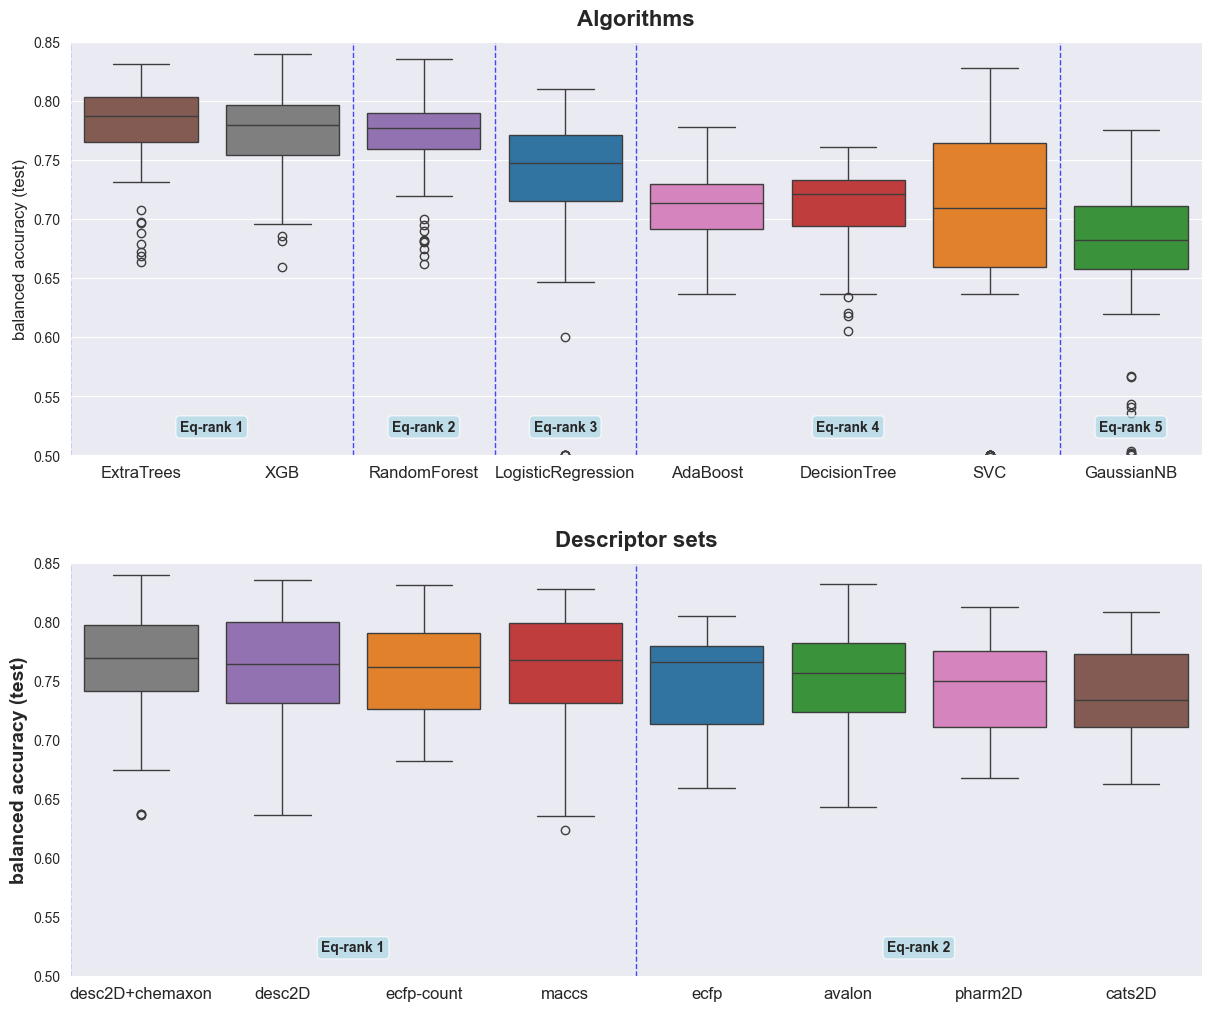

In [141]:
plot_test_results_by_metric(pre_split_results_classification, classification_main_metric, exclude_models_from_featuriser_evaluation=["DummyClassifier"], ylim=[0.5, 0.85])

plt.savefig("figures/figure_2.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [131]:
print("Top performing featuriser / model combinations in the pre-split classification setting:")
get_best_models_featurisers_by_metric(pre_split_results_classification, classification_main_metric)

Top performing featuriser / model combinations in the pre-split classification setting:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


,eq_rank,results_w_avg,featuriser,model
311,1,0.813441,desc2D,ExtraTreesClassifier
743,1,0.811069,desc2D+chemaxon,ExtraTreesClassifier
755,1,0.810675,desc2D+chemaxon,XGBClassifier
323,1,0.808452,desc2D,XGBClassifier
377,1,0.806413,mordred,XGBClassifier
...,...,...,...,...
167,1,0.500000,maccs,DummyClassifier
113,1,0.500000,avalon,DummyClassifier
59,1,0.500000,ecfp-count,DummyClassifier
383,1,0.500000,cats2D,DummyClassifier


### Pre-split baseline - regression

Started evaluation using 878 compounds
Evaluating ecfp
 - model: DummyRegressor
 - model: LinearRegression
 - model: Ridge
 - model: SVR
 - model: DecisionTreeRegressor
 - model: ExtraTreesRegressor
 - model: RandomForestRegressor
 - model: AdaBoostRegressor
 - model: XGBRegressor
Evaluating ecfp-count
 - model: DummyRegressor
 - model: LinearRegression
 - model: Ridge
 - model: SVR
 - model: DecisionTreeRegressor
 - model: ExtraTreesRegressor
 - model: RandomForestRegressor
 - model: AdaBoostRegressor
 - model: XGBRegressor
Evaluating avalon
 - model: DummyRegressor
 - model: LinearRegression
 - model: Ridge
 - model: SVR
 - model: DecisionTreeRegressor
 - model: ExtraTreesRegressor
 - model: RandomForestRegressor
 - model: AdaBoostRegressor
 - model: XGBRegressor
Evaluating maccs
 - model: DummyRegressor
 - model: LinearRegression
 - model: Ridge
 - model: SVR
 - model: DecisionTreeRegressor
 - model: ExtraTreesRegressor
 - model: RandomForestRegressor
 - model: AdaBoostRegressor
 - 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:227: RuntimeWarning: divide by zero encountered in scalar divide
  z -= sign * 0.5 / se
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:227: RuntimeWarning: divide by zero encountered in scalar divide
  z -= sign * 0.5 / se


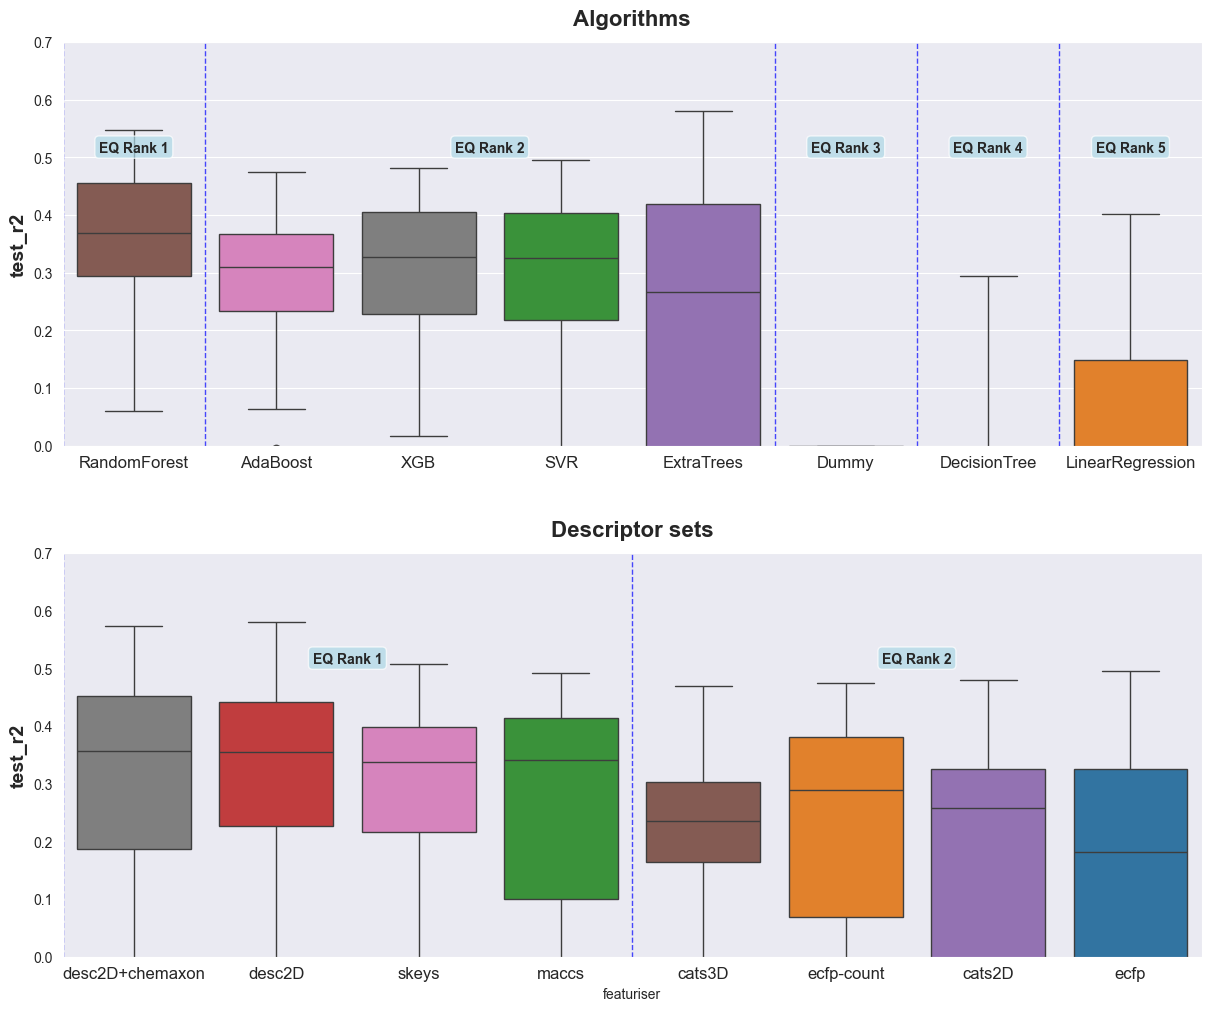

In [132]:
pre_split_results_regression, _raw_pre_split_results_regression = evaluate_setting(
    data=df_cns_db_shuffled,
    feature_cache=cns_db_shuffled_descriptors_cache,
    featurisers=[f[0] for f in featurisers], 
    models=get_regression_models(),
    data_idx=cns_db_shuffled_idx_regression,
    metrics=regression_metrics, 
    target_func=cns_db_regression_target,
    groups_func=groups_murcko_scaffold_group
)

#plot_test_results_by_metric(pre_split_results_regression[pre_split_results_regression.model != "desc3d"], metric, exclude_models_from_featuriser_evaluation=["DummyRegressor"])
plot_test_results_by_metric(pre_split_results_regression, regression_main_metric, exclude_models_from_featuriser_evaluation=["DummyRegressor"], ylim=(0, 0.7))

In [133]:
print("Top performing featuriser / model combinations in the pre-split regression setting:") 
get_best_models_featurisers_by_metric(pre_split_results_regression, regression_main_metric)

Top performing featuriser / model combinations in the pre-split regression setting:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


,eq_rank,results_w_avg,featuriser,model
178,1,4.889418e-01,mordred,ExtraTreesRegressor
367,1,4.733419e-01,desc2D+chemaxon,ExtraTreesRegressor
151,1,4.702667e-01,desc2D,ExtraTreesRegressor
370,1,4.685038e-01,desc2D+chemaxon,RandomForestRegressor
181,1,4.674471e-01,mordred,RandomForestRegressor
...,...,...,...,...
58,1,-4.117158e+00,avalon,LinearRegression
169,1,-5.400916e+01,mordred,Ridge
166,1,-7.271151e+09,mordred,LinearRegression
112,1,-1.487953e+11,desc3D,LinearRegression


## Training / Test split
We split using Twinning algorithm https://doi.org/10.1002/sam.11574. 
We considered 2 strategies to limit the structural information leakage form the test to the training set (i.e. maintain scaffold split): 
 - Perform Twinning with a smaller partitioning ratio (i.e. r=10 in place of r=5 given the scaffold / record ratio of ~1/2) and subsequently move all examples from the training set that share the scaffold with any molecules in the test set to the test set. 
 - Aggregate scaffold values utilising means or medians. This is feasible since the descriptors include since all the descriptors are continuous and non-empty. Perform the split of aggregated scaffolds. 
 

In [13]:
featurisers_for_tt_split = [
    "desc2D+chemaxon", # classification eq-rank 1 / reg eq-rank 1  
    "maccs",           # classification eq-rank 1 
    "ecfp-count",      # classification eq-rank 1
    "skeys",           # regression eq-rank 1 /t classification eq-rank 2
    "cats3D",          # regression eq-rank 2 / classification eq-rank 2
    "cats2D",          # classification eq-rank 2 - included to complement with cats3D
] 
df_desc_for_split = pd.concat([cns_db_shuffled_descriptors_cache[f].add_prefix(f"{f}_") for f in featurisers_for_tt_split], axis=1).join(df_cns_db_shuffled["murcko_scaffold_grouped"])


Test set grouped Murcko scaffold using scaffold means :
 - classification 645 / 3322 (19.42%)
     positives ratio (vs training): 1.022
 - regression     198 / 878 (22.55%)
     logBB KS stat (vs training): 0.064 pval: 0.027
Wasserstein Distance (t-SNE Dim 1): 3.34
Wasserstein Distance (t-SNE Dim 2): 0.955


{'name': 'scaffold means',
 'n_classification': 645,
 'positives_ratio': 1.022,
 'n_regression': 198,
 'ks_logBB_stat': 0.064,
 'ks_logBB_pval': 0.027,
 'wasserstein_distance_tsne_dim_1': 3.34,
 'wasserstein_distance_tsne_dim_2': 0.955}

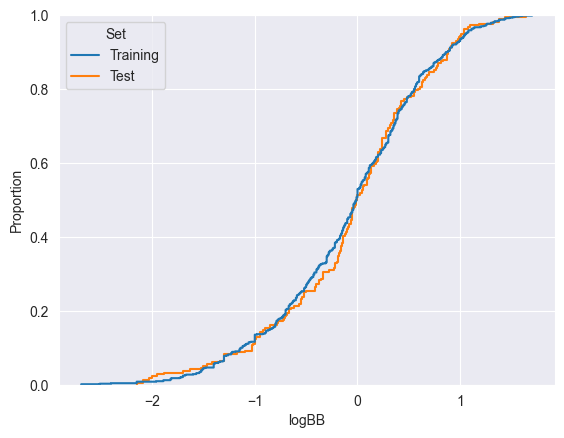

In [24]:


_classification_total =  len(df_cns_db_shuffled)
_regression_total = sum(cns_db_shuffled_idx_regression)
def analyse_test_scaffolds(test_scaffolds, name, visualise=False):
    _idx_test = list(df_cns_db_shuffled.murcko_scaffold_grouped.apply(lambda x: x in test_scaffolds))
    _idx_train = list(not i for i in _idx_test)
    _idx_test_reg = list(df_cns_db_shuffled.apply(axis=1, func=lambda x: x.murcko_scaffold_grouped in test_scaffolds and (pd.notna(x.logBB_group) and x.logBB_group != "D")))
    _n_classification = sum(_idx_test)
    _positives_ratio = round((sum(df_cns_db_shuffled[_idx_test]["BBB+/BBB-"] == "BBB+") / sum(_idx_test)) / (sum(df_cns_db_shuffled[_idx_train]["BBB+/BBB-"] == "BBB+") / sum(_idx_train)), 3)
    _n_regression = sum(_idx_test_reg)
    _pc_classification = _n_classification / _classification_total
    _pc_regression = _n_regression / _regression_total
    _ks_logBB_stat, _ks_logBB_pval = ks_2samp(df_cns_db_shuffled[_idx_test].logBB, df_cns_db_shuffled[_idx_train].logBB)
    _ks_logBB_stat = round(_ks_logBB_stat, 3)
    _ks_logBB_pval = round(_ks_logBB_pval, 3)
    
    if visualise:
        print(f"Test set grouped Murcko scaffold using {name} :")
        print(f" - classification {_n_classification} / {_classification_total} ({_n_classification / _classification_total:.02%})")
        print(f"     positives ratio (vs training):", _positives_ratio)
        print(f" - regression     {_n_regression} / {_regression_total} ({_n_regression / _regression_total:.02%})")
        print(f"     logBB KS stat (vs training): {_ks_logBB_stat} pval: {_ks_logBB_pval}")
         
        _df = df_cns_db_shuffled[["logBB", "murcko_scaffold_grouped"]].copy()
        _df["Set"] = _df.murcko_scaffold_grouped.apply(lambda x: "Test" if x in test_scaffolds else "Training")
        sns.ecdfplot(data=_df, x='logBB', hue="Set", stat='proportion')
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(df_desc_for_split.drop(columns=["murcko_scaffold_grouped"]))
    
        
    _train = tsne_results[~df_cns_db_shuffled.murcko_scaffold_grouped.apply(lambda x: x in test_scaffolds)]
    _test = tsne_results[df_cns_db_shuffled.murcko_scaffold_grouped.apply(lambda x: x in test_scaffolds)]
    wass_dist_dim1 = round(wasserstein_distance(_train[:, 0], _test[:, 0]), 3)
    wass_dist_dim2 = round(wasserstein_distance(_train[:, 1], _test[:, 1]), 3)
    if visualise:
        print(f"Wasserstein Distance (t-SNE Dim 1): {wass_dist_dim1}")
        print(f"Wasserstein Distance (t-SNE Dim 2): {wass_dist_dim2}")
        
        _df = pd.DataFrame({
            't-SNE 1': tsne_results[:, 0],
            't-SNE 2': tsne_results[:, 1],
            'Label': df_cns_db_shuffled.murcko_scaffold_grouped.apply(lambda x: x in test_scaffolds),
            'SMILES': list(df_cns_db.smiles),
            'names': list(df_cns_db.names),
        })
        
        fig = px.scatter(
            _df, x='t-SNE 1', y='t-SNE 2', color='Label', hover_data=['names'], 
            size_max=2, opacity=0.5
        )
        fig.update_layout(
            title='Interactive t-SNE Projection of Molecular Descriptors',
            xaxis_title='t-SNE 1',
            yaxis_title='t-SNE 2',
            width=1000,  # Adjust the figure width
            height=800,  # Adjust the figure height
            template="plotly_dark"  # Use dark theme
        )
        fig.show()
    return {
        "name": name,
        "n_classification": _n_classification,
        "positives_ratio": _positives_ratio,
        "n_regression": _n_regression,
        "ks_logBB_stat": _ks_logBB_stat,
        "ks_logBB_pval": _ks_logBB_pval,
        "wasserstein_distance_tsne_dim_1": wass_dist_dim1,
        "wasserstein_distance_tsne_dim_2": wass_dist_dim2
    }

# Random strategy     
#analyse_test_scaffolds(list(df_desc_for_split.murcko_scaffold_grouped.sample(230)), "randomisation", visualise=True)

# Molecule properties for twinning - extend to scaffold
#_by_mol = list(df_desc_for_split.iloc[twinning.twin(df_desc_for_split.drop(columns=["murcko_scaffold_grouped"]).to_numpy(), r=14, u1=5)].murcko_scaffold_grouped)
#analyse_test_scaffolds(_by_mol, "by molecule properties", visualise=True)

# Median
# g_scaffold_desc_for_split_median = df_desc_for_split.groupby("murcko_scaffold_grouped").median()
# test_scaffolds_twinning_scaffold_median = set(g_scaffold_desc_for_split_median.index[twinning.twin(g_scaffold_desc_for_split_median.to_numpy(), r=5, u1=48)])
#analyse_test_scaffolds(test_scaffolds_twinning_scaffold_median, name="scaffold medians", visualise=True)

g_scaffold_desc_for_split_mean = df_desc_for_split.groupby("murcko_scaffold_grouped").mean()
# u1 was set empirically based on the proportion of the molecule records in the regression and classification sets, positive cases ration between training and testing, Wasserstein (Earth mover) distance across TSNE dim 1 and dim 2 and Kolmogorov–Smirnov test for logBB distribution.
test_scaffolds_twinning_scaffold_mean = set(g_scaffold_desc_for_split_mean.index[twinning.twin(g_scaffold_desc_for_split_mean.to_numpy(), r=5, u1=2)])  # alternative is u1=36 ui=43 u1=23, u1=4
analyse_test_scaffolds(test_scaffolds_twinning_scaffold_mean, name="scaffold means", visualise=True)



In [18]:
# Multiple train-test Twinning-based split assessment:
# - scaffold means 
# - scaffold medians
# - molecule properties, extending to scaffolds
# - randomised

g_scaffold_desc_for_split_mean = df_desc_for_split.groupby("murcko_scaffold_grouped").mean()
res = []
n_seeds = 50
for u1 in range(n_seeds):
    res.append(
        analyse_test_scaffolds(set(g_scaffold_desc_for_split_mean.index[twinning.twin(g_scaffold_desc_for_split_mean.to_numpy(), r=5, u1=u1)]), name=f"scaffold means, u1={u1}", visualise=False
   )
)
g_scaffold_desc_for_split_median = df_desc_for_split.groupby("murcko_scaffold_grouped").median()
for u1 in range(n_seeds):
    res.append(
        analyse_test_scaffolds(set(g_scaffold_desc_for_split_median.index[twinning.twin(g_scaffold_desc_for_split_median.to_numpy(), r=5, u1=u1)]), name=f"scaffold median, u1={u1}", visualise=False)
    )
for u1 in range(n_seeds):
    res.append(
        analyse_test_scaffolds(set(df_desc_for_split.iloc[twinning.twin(df_desc_for_split.drop(columns=["murcko_scaffold_grouped"]).to_numpy(), r=14, u1=u1)].murcko_scaffold_grouped), name=f"by mol properties, u1={u1}", visualise=False)
    )
for u1 in range(n_seeds):
    res.append(analyse_test_scaffolds(list(df_desc_for_split.murcko_scaffold_grouped.sample(240, random_state=u1)), name=f"240 random, state={u1}", visualise=False))

_df = pd.DataFrame(res)
_df[(abs(_df.positives_ratio -1) <0.07) & (_df.n_regression > 165) & (_df.wasserstein_distance_tsne_dim_1 < 5 )].sort_values("ks_logBB_pval", ascending=True)

,name,n_classification,positives_ratio,n_regression,ks_logBB_stat,ks_logBB_pval,wasserstein_distance_tsne_dim_1,wasserstein_distance_tsne_dim_2
168,"240 random, state=18",728,1.046,181,0.067,0.011,3.622,1.885
56,"scaffold median, u1=6",673,1.031,208,0.065,0.019,2.450,1.646
99,"scaffold median, u1=49",674,1.011,202,0.065,0.021,2.451,2.230
2,"scaffold means, u1=2",645,1.022,198,0.064,0.027,3.340,0.955
74,"scaffold median, u1=24",649,0.996,189,0.062,0.034,2.495,2.721
23,"scaffold means, u1=23",645,1.004,181,0.059,0.050,4.005,2.315
60,"scaffold median, u1=10",674,1.023,200,0.056,0.069,3.102,1.897
37,"scaffold means, u1=37",636,0.994,186,0.052,0.121,3.112,3.587
97,"scaffold median, u1=47",642,0.980,182,0.050,0.143,4.271,2.071
10,"scaffold means, u1=10",614,0.938,180,0.050,0.162,3.545,3.146


In [25]:
df_cns_db["split"] = df_cns_db.murcko_scaffold_grouped.apply(lambda x: "test" if x in test_scaffolds_twinning_scaffold_mean else "training")
df_cns_db_to_dump = df_cns_db.drop(columns=["mol", "mol_conformers", "murcko_scaffold", "murcko_scaffold_grouped", "ecfp4_count_fingerprint"])
df_cns_db_to_dump.to_csv("cns_db_split.tsv", index=False, sep="\t")

In [26]:
desc_for_split_with_smiles = df_cns_db_shuffled[["smiles"]].reset_index(drop=True).join(df_desc_for_split)
df_cns_db_to_dump_with_descriptors = df_cns_db_to_dump.merge(desc_for_split_with_smiles, on="smiles")
df_cns_db_to_dump_with_descriptors = df_cns_db_to_dump_with_descriptors.rename(columns={k: k.replace("desc2D+" if k.split("_", 1)[-1] in {"logd", "logp", "pka_b"} else "+chemaxon", "") if k.startswith("desc2D+chemaxon") else k for k in list(df_cns_db_to_dump_with_descriptors)})
df_cns_db_to_dump_with_descriptors.to_csv("cns_db_split_descriptors.tsv", index=False, sep="\t")